In [1]:
import os, sys
import numpy as np
import geopandas as gpd
sys.path.append('../')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from onsstove.onsstove import OnSSTOVE, DataProcessor
from onsstove.layer import RasterLayer, VectorLayer
from onsstove.raster import interpolate
import time

# Data processing

## 1. Create a data processor

In [ ]:
start = time.time()

data = DataProcessor(project_crs=3857, cell_size=(1000, 1000))
output_directory = 'CCE Storylines'
data.output_directory = output_directory

## 2. Add a mask layer (country boundaries)

In [ ]:
adm_path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\NPL_adm0_Nepal0.shp"
data.add_mask_layer(category='Administrative', name='Country_boundaries', layer_path=adm_path)

## 3. Add GIS layers

### Demographics

In [ ]:
pop_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Population\HRSL\population_npl_2018-10-01_geotiff\population_npl_2018-10-01.tif"
data.add_layer(category='Demographics', name='Population', layer_path=pop_path, layer_type='raster', base_layer=True, resample='sum')

# Check if this is needed for a general implementation
# data.layers['Demographics']['Population'].layer[np.isnan(data.layers['Demographics']['Population'].layer)] = 0
# data.layers['Demographics']['Population'].save(os.path.join(data.output_directory, 'Demographics', 'Population'))

ghs_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Urban - Rural divide\GHS.tif"
data.add_layer(category='Demographics', name='Urban_rural_divide', layer_path=ghs_path, layer_type='raster', resample='nearest')

### Biomass

In [ ]:
forest_path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Forest cover\Forest_cover_2020.tif"
data.add_layer(category='Biomass', name='Forest', layer_path=forest_path, layer_type='raster', resample='average')

friction_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Walking friction\2020_walking_only_friction_surface.geotiff"
data.add_layer(category='Biomass', name='Friction', layer_path=friction_path, layer_type='raster', resample='average', window=True)

### Electricity

In [ ]:
mv_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MV-network\Nepal_DL0.shp"
data.add_layer(category='Electricity', name='MV_lines', layer_path=mv_path, layer_type='vector')

mg_path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Power network\MG-hydro\micro_hydropower.shp"
data.add_layer(category='Electricity', name='MG', layer_path=mg_path, layer_type='vector')

ntl_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Night Time Lights\nighttime lights.tif"
data.add_layer(category='Electricity', name='Night_time_lights', layer_path=ntl_path, layer_type='raster', resample='average')

### LPG

In [ ]:
# lpg_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\LPG\Nepal_Gas_12Jun2021_Final4.shp"
# data.add_layer(category='LPG', name='Suppliers', layer_path=lpg_path, layer_type='vector')

# friction_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Motorized friction\2020_motorized_friction_surface.geotiff"
# data.add_layer(category='LPG', name='Friction', layer_path=friction_path, layer_type='raster', resample='average', window=True)

lpg_path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Traveltime\traveltime_to_urban_by_road.tif"
data.add_layer(category='LPG', name='LPG Traveltime', layer_path=lpg_path, layer_type='raster', resample='average')

### Biogas

In [ ]:
temperature = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Temperature\TEMP.tif"
data.add_layer(category='Biogas', name='Temperature', layer_path=temperature,
               layer_type='raster', resample='average', window=True)
data.layers['Biogas']['Temperature'].save(f'{data.output_directory}/Biogas/Temperature')

## 4. Mask reproject and align all required layers

In [ ]:
data.mask_layers(datasets={'Demographics': ['Population', 'Urban_rural_divide'],
                           'Biomass': ['Forest', 'Friction'],
                           'Electricity': ['Night_time_lights'],
                           'LPG': ['LPG Traveltime'],
                           'Biogas': ['Temperature']})

In [ ]:
data.align_layers(datasets='all')

In [ ]:
data.reproject_layers(datasets={'Electricity': ['MG', 'MV_lines']})

In [ ]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

# Model preparation

## 1. Create an OnSSTOVE model

In [9]:
start = time.time()

nepal = OnSSTOVE()
output_directory = 'CCE Storylines'
nepal.output_directory = output_directory

## 2. Read the model data

In [10]:
path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\Nepal_social_specs_new.csv"
nepal.read_scenario_data(path, delimiter=',')

## 3. Add a country mask layer

In [11]:
path = os.path.join(output_directory, 'Administrative', 'Country_boundaries', 'Country_boundaries.geojson')
mask_layer = VectorLayer('admin', 'adm_0', layer_path=path)
nepal.mask_layer = mask_layer

## 4. Add a population base layer

In [12]:
path = os.path.join(output_directory, 'Demographics', 'Population', 'Population.tif')
nepal.add_layer(category='Demographics', name='Population', layer_path=path, layer_type='raster', base_layer=True)
nepal.population_to_dataframe()

In [13]:
# path = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\Admin lvl 1.shp"
# nepal.add_admin_names(path, 'ADM1_EN')

## 5. Calibrate population and urban/rural split

In [14]:
nepal.calibrate_current_pop()

# path = os.path.join(output_directory, 'Demographics', 'Urban_rural_divide', 'Urban_rural_divide.tif')
ghs_path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Urban - Rural divide\GHS.tif"
nepal.calibrate_urban_current_and_future_GHS(ghs_path)

## 6. Add wealth index GIS data

In [15]:
# wealth_index = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\npl_relative_wealth_index.csv"
# nepal.extract_wealth_index(wealth_index, file_type="csv", 
#                            x_column="longitude", y_column="latitude", wealth_column="rwi")

wealth_index = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Demand\Wealth Index\Wealth index 2011.tif"
nepal.extract_wealth_index(wealth_index, file_type="raster")

## 7. Calculate value of time

In [16]:
# Based on wealth index, minimum wage and a lower an upper range for cost of oportunity
nepal.get_value_of_time()

## 8. Read electricity network GIS layers

In [17]:
# Read MV lines
path = os.path.join(output_directory, 'Electricity', 'MV_lines', 'MV_lines.geojson')
mv_lines = VectorLayer('Electricity', 'MV_lines', layer_path=path)

# Read MG
path = os.path.join(output_directory, 'Electricity', 'MG', 'mg.geojson')
mg = VectorLayer('Electricity', 'MG', layer_path=path)

### 8.1. Calculate distance to electricity infrastructure 

In [18]:
nepal.distance_to_electricity(transformers=mg, mv_lines=mv_lines)

In [19]:
# nepal.gdf['Transformers_dist'] = nepal.gdf[['MV_lines_dist', 'MG_dist']].min(axis=1)

In [20]:
# nepal.specs['Elec_rate'] = 0.9

### 8.2. Add night time lights data

In [21]:
path = os.path.join(output_directory, 'Electricity', 'Night_time_lights', 'Night_time_lights.tif')
ntl = RasterLayer('Electricity', 'Night_time_lights', layer_path=path)

nepal.raster_to_dataframe(ntl.layer, name='Night_lights', method='read')

## 9. Calibrate current electrified population

In [22]:
nepal.current_elec()
nepal.final_elec()

print('Calibrated grid electrified population fraction:', nepal.gdf['Elec_pop_calib'].sum() / nepal.gdf['Calibrated_pop'].sum())

Calibrated grid electrified population fraction: 0.713435698274817


## 10. Read the cooking technologies data

In [23]:
path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\Nepal_tech_specs_new.csv"
nepal.read_tech_data(path, delimiter=',')

## 11. Calculating grid added capacity cost

In [24]:
# nepal.techs['Electricity'].grid_capacity_cost = 0
nepal.techs['Electricity'].get_capacity_cost(nepal)

## 12. Reading GIS data for LPG supply

In [25]:
# nepal.techs['LPG'].lpg_path = os.path.join(nepal.output_directory, 'LPG', 'Suppliers', 'Suppliers.geojson')
# nepal.techs['LPG'].friction_path = os.path.join(nepal.output_directory, 'LPG', 'Friction', 'Friction.tif')

# nepal.techs['LPG'].add_travel_time(nepal)
lpg = RasterLayer('LPG', 'LPG Traveltime', 
                  os.path.join(nepal.output_directory, 'LPG', 'LPG Traveltime', 'LPG Traveltime.tif'))
nepal.techs['LPG'].travel_time = 2 * lpg.layer / 60

## 13. Adding GIS data for Improved Biomass collected (ICS biomass)

In [26]:
nepal.techs['Collected_Traditional_Biomass'].friction_path = os.path.join(nepal.output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Collected_Traditional_Biomass'].forest_path = os.path.join(nepal.output_directory, 'Biomass', 'Forest', 'Forest.tif')
nepal.techs['Collected_Traditional_Biomass'].forest_condition = lambda x: x > 30

nepal.techs['Collected_Improved_Biomass'].friction_path = os.path.join(nepal.output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Collected_Improved_Biomass'].forest_path = os.path.join(nepal.output_directory, 'Biomass', 'Forest', 'Forest.tif')
nepal.techs['Collected_Improved_Biomass'].forest_condition = lambda x: x > 30

## 14. Adding GIS data for Improved Biomass collected (ICS biomass)

In [27]:
admin = gpd.read_file(r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Other\Administrative boundaries\Admin lvl 0.shp")
buffaloes = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Buffaloes\5_Bf_2010_Da.tif"
cattles = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Cattle\5_Ct_2010_Da.tif"
poultry = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Chickens\5_Ch_2010_Da.tif"
goats = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Goats\5_Gt_2010_Da.tif"
pigs = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Pigs\5_Pg_2010_Da.tif"
sheeps = r"..\EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\GIS-data\Supply\Global livestock\Sheep\5_Sh_2010_Da.tif"
temp_path = os.path.join(nepal.output_directory, 'Biogas', 'Temperature', 'Temperature.tif')
temperature = RasterLayer('Biogas', 'Temperature', temp_path)
# water = VectorLayer('Biogas', 'Water scarcity', 
#                     r"..\Clean cooking Africa paper\01. Data\GIS-data\Water scarcity\y2019m07d11_aqueduct30_annual_v01.gpkg", 
#                     bbox=nepal.mask_layer.layer)

nepal.techs['Biogas'].recalibrate_livestock(nepal, buffaloes, cattles, poultry, goats, pigs, sheeps)
nepal.techs['Biogas'].friction_path = os.path.join(nepal.output_directory, 'Biomass', 'Friction', 'Friction.tif')
nepal.techs['Biogas'].available_biogas(nepal)
nepal.techs['Biogas'].available_energy(nepal, temperature)

## 15. Saving the prepared model inputs

In [28]:
nepal.to_pickle("Policy1.pkl")

In [29]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

Execution time: 0 min 45 sec


# Model run

## 1. Read the OnSSTOVE model

In [63]:
start = time.time()
folder = 'CCE Storylines'
nepal = OnSSTOVE.read_model(f"{folder}/Policy1.pkl")

In [64]:
nepal.specs['w_social'] = 0

## 2. Read the scenario data

In [65]:
# path = r"../EGI Energy Systems\06 Projects\2021 Nepal Geospatial cooking\02 - work\OnSSTOVE cases\NP_test_file_social_specs.csv"
# nepal.read_scenario_data(path, delimiter=',')

## 3. Calculating benefits and costs of each technology and getting the max benefit technology for each cell

In [66]:
# names = ['Electricity', 'Collected_Traditional_Biomass', 'Collected_Improved_Biomass', 'Charcoal', 'Charcoal ICS', 'LPG', 'Biogas']
names = ['Electricity', 'LPG', 'Biogas']
nepal.run(technologies=names)

[Nepal] Calculating clean cooking access
[Nepal] Calculating base fuel properties
[Nepal] Getting value of time
Calculating health benefits for Electricity...
Calculating carbon emissions benefits for Electricity...
Calculating time saved benefits for Electricity...
Calculating costs for Electricity...
Calculating net benefit for Electricity...

Calculating health benefits for LPG...
Calculating carbon emissions benefits for LPG...
Calculating time saved benefits for LPG...
Calculating costs for LPG...
Calculating net benefit for LPG...

Calculating health benefits for Biogas...
Calculating carbon emissions benefits for Biogas...
Calculating time saved benefits for Biogas...
Calculating costs for Biogas...
Calculating net benefit for Biogas...

Getting maximum net benefit technologies...
Extracting indicators...
    - Lives saved
    - Health costs
    - Time saved
    - Opportunity cost
    - Avoided emissions
    - Avoided emissions costs
    - Investment costs
    - Fuel costs
    -

## 4. Printing the results

In [105]:
nepal.summary()

,Max benefit technology,Population (Million),Total net benefit (MMUSD),Total deaths avoided (pp/yr),Health costs avoided (MMUSD),hours/pp.day,Opportunity cost avoided (MMUSD),Reduced emissions (Mton CO2eq),Emissions costs saved (MMUSD),Investment costs (MMUSD),Fuel costs (MMUSD),O&M costs (MMUSD),Salvage value (MMUSD)
0,Biogas,0.668071,37.437407,414.332196,53.523673,0.681147,31.093949,17.501986,0.737268,75.652176,-5.135010,0.0,60.991915
1,Electricity,20.787376,1553.247377,22421.583190,2986.233816,1.138932,1675.145837,10542.303365,19.437373,118.223385,64.951323,0.0,69.478111
2,LPG,7.681553,299.948756,4717.503009,609.413605,1.237547,577.901223,203.326634,6.826837,35.148738,274.406421,0.0,26.651673
total,total,29.137000,1890.633541,27553.418395,3649.171093,1.154434,2284.141009,10763.131986,27.001477,229.024299,334.222734,0.0,157.121699


## 5. Saving data to raster files

In [74]:
cmap = {"ICS": '#57365A', "LPG": '#38a6a5', "Traditional biomass": '#673139', "Charcoal": '#B6195E',
        "Biogas": '#73af48', "Biogas and ICS": "#F6029E",
        "Biogas and LPG": "#1d6996",  "Biogas and Traditional biomass": "#266AA6",
        "Biogas and Charcoal": "#3B05DF", "Biogas and Electricity": "#484673",
        "Electricity": '#cc503e', "Electricity and ICS": "#4D7126",
        "Electricity and LPG": "#e17c05", "Electricity and Traditional biomass": "#FFC107",
        "Electricity and Charcoal": "#1E88E5", "Electricity and Biogas": "#0f8554"}

labels = {"Biogas and Electricity": "Electricity and Biogas",
          'Collected Traditional Biomass': 'Traditional biomass',
          'Collected Improved Biomass': 'ICS'}

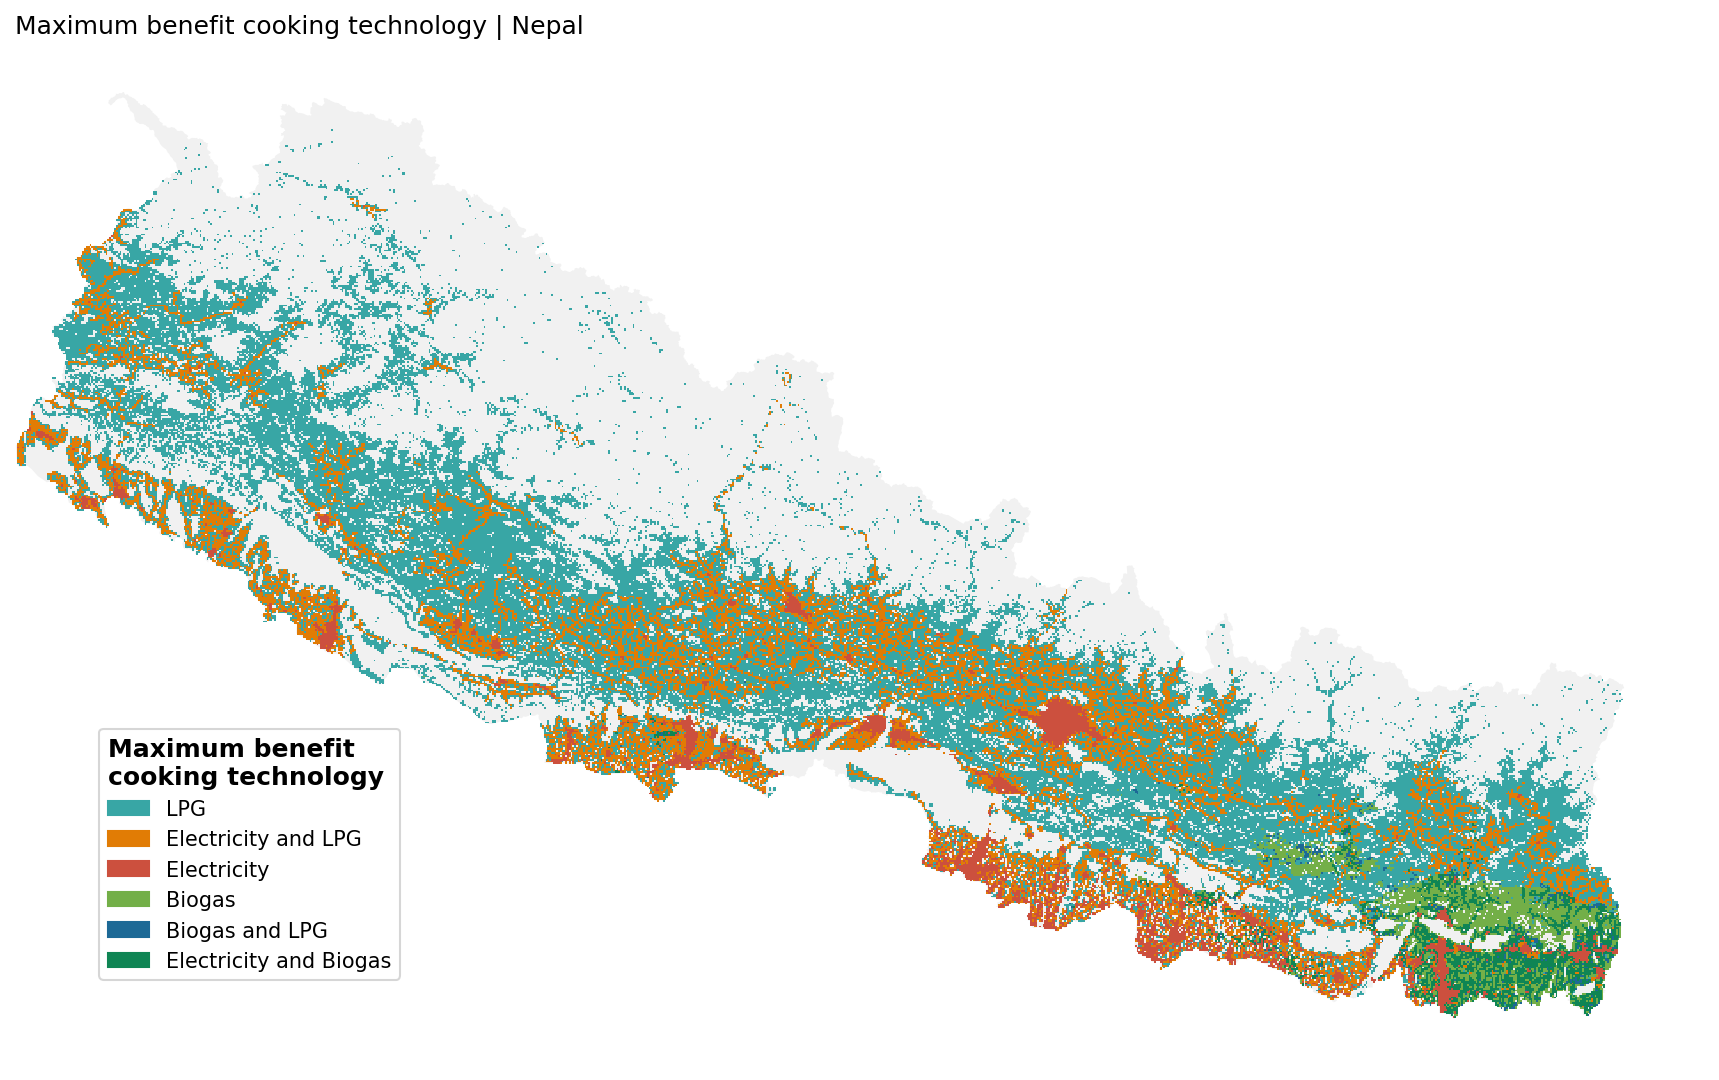

In [75]:
nepal.plot('max_benefit_tech', cmap=cmap, legend_position=(0.05, 0.33),
           title=f'Maximum benefit cooking technology | Nepal', 
           labels=labels, legend=True, legend_title='Maximum benefit\ncooking technology', 
           rasterized=True)

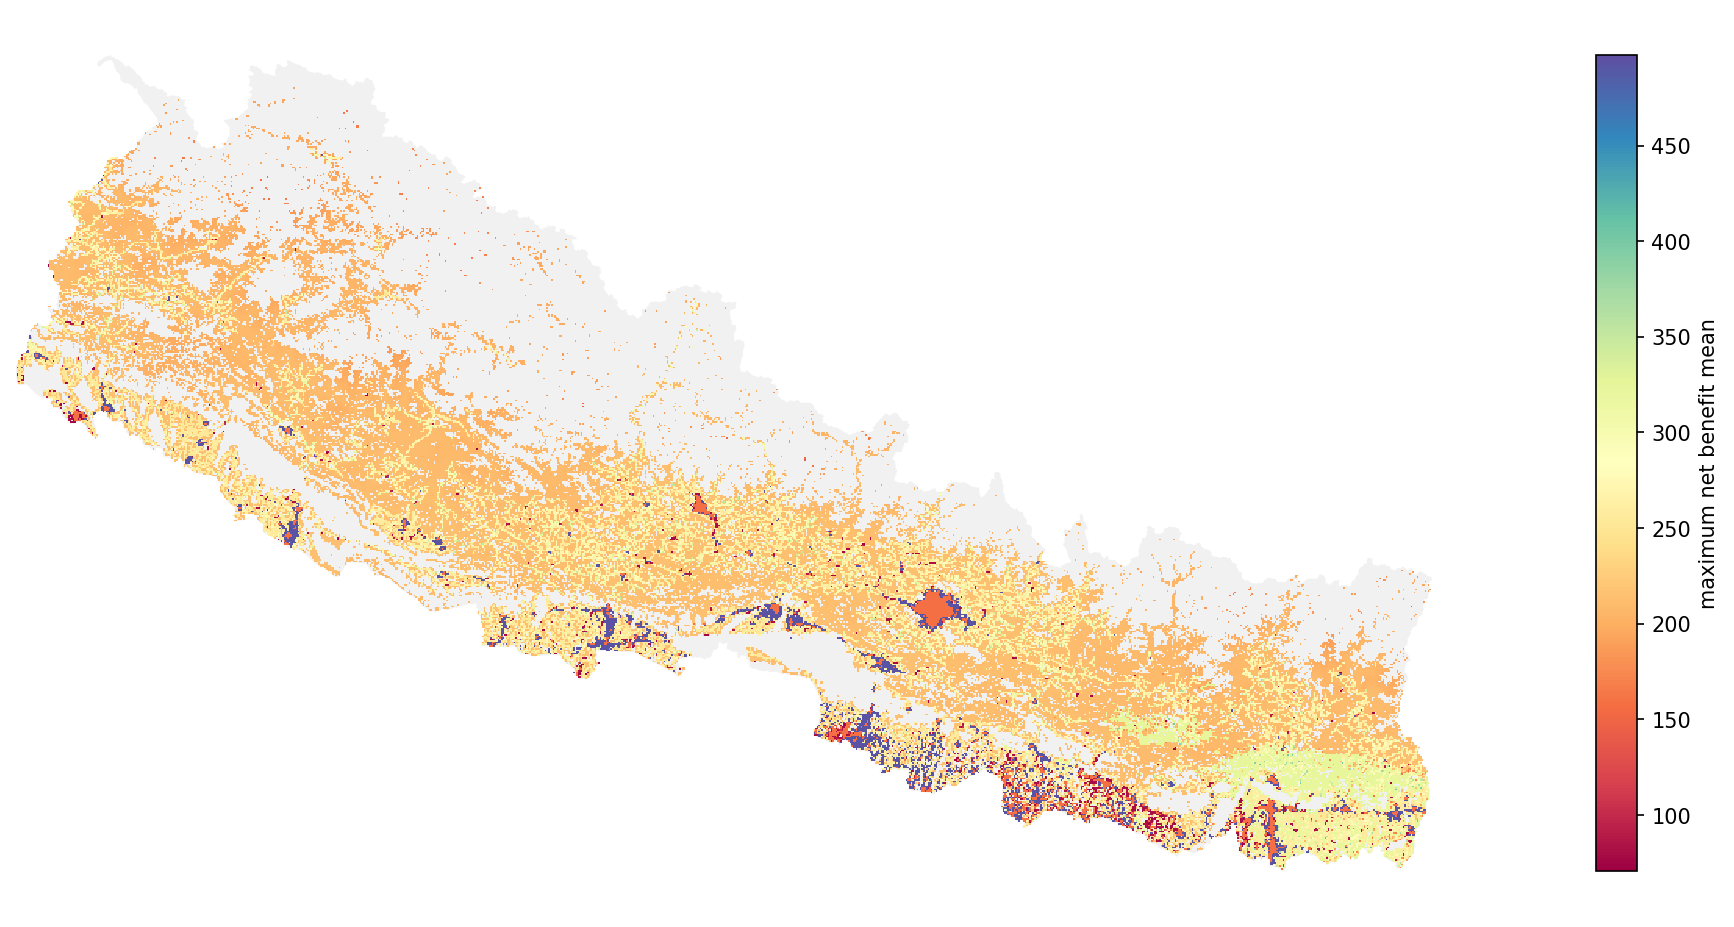

In [78]:
nepal.plot('maximum_net_benefit', cmap='Spectral', metric='mean')

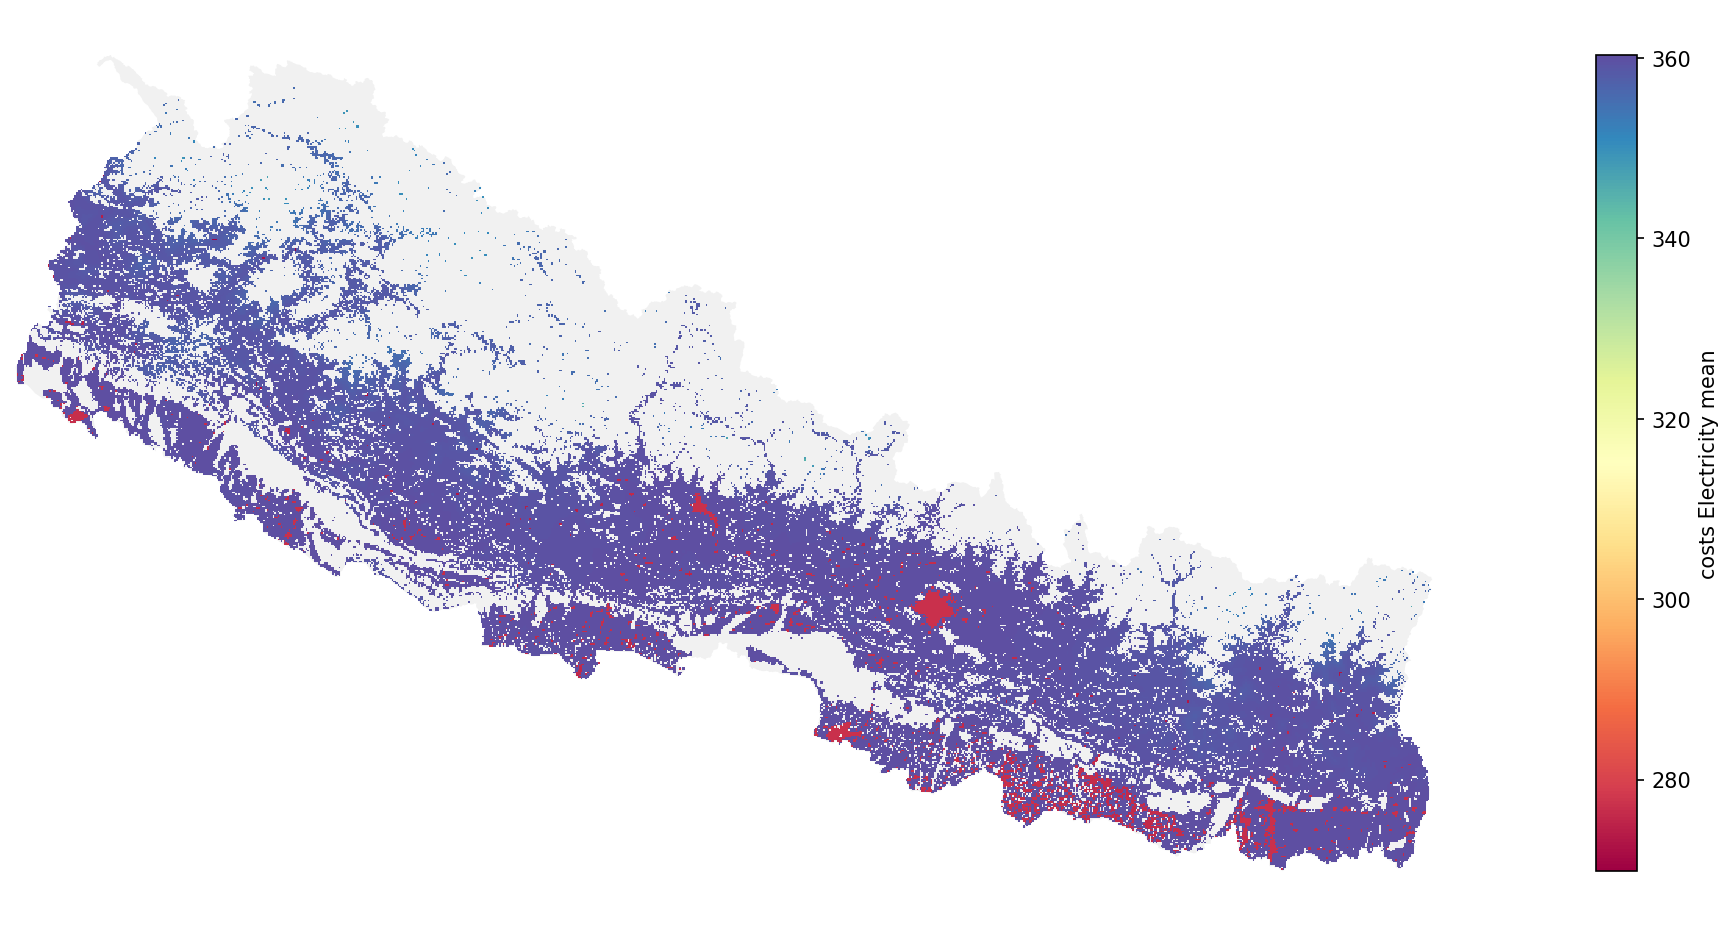

In [79]:
nepal.plot('costs_Electricity', cmap='Spectral', metric='mean')

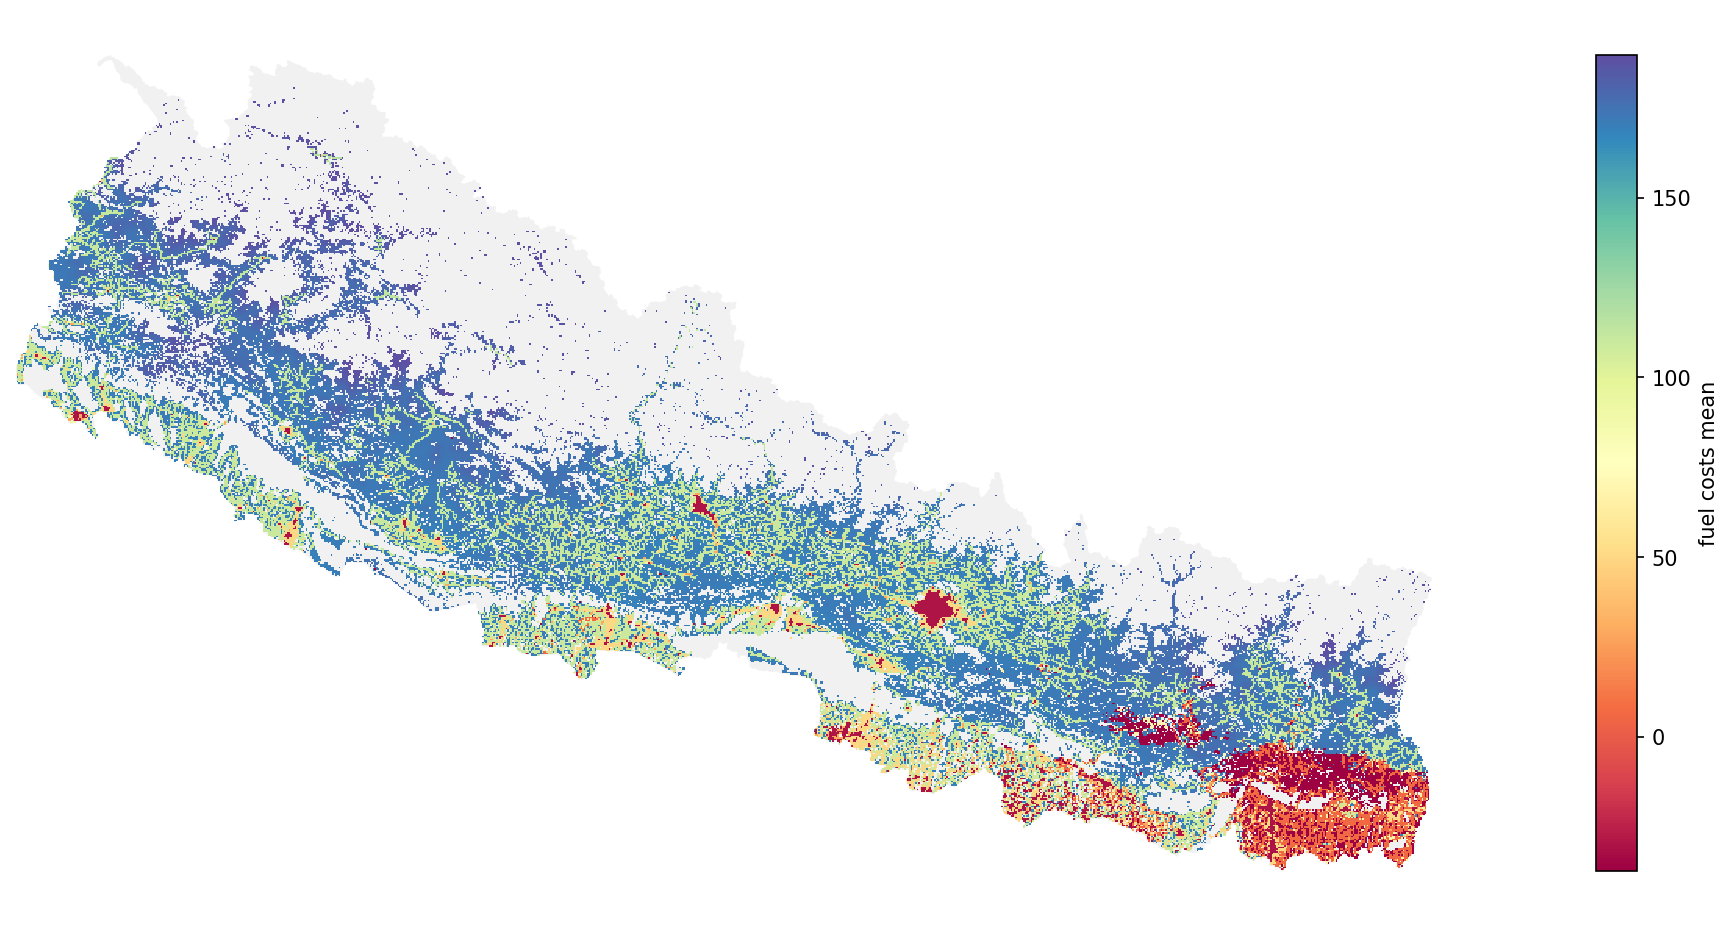

In [83]:
nepal.plot('fuel_costs', cmap='Spectral', cumulative_count=(0.01, 0.99), metric='mean')

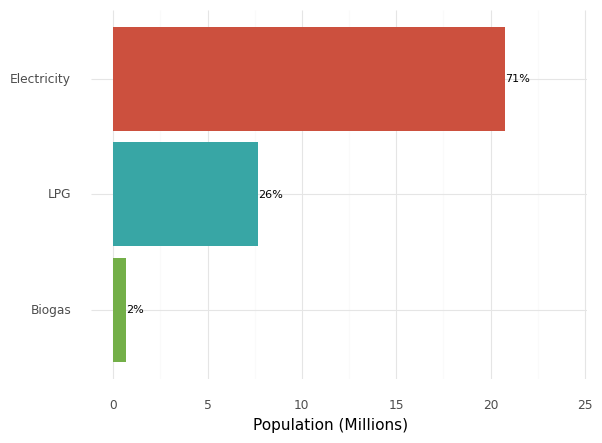

<ggplot: (123728450738)>

In [84]:
nepal.plot_split(cmap=cmap, labels=labels, save=False)

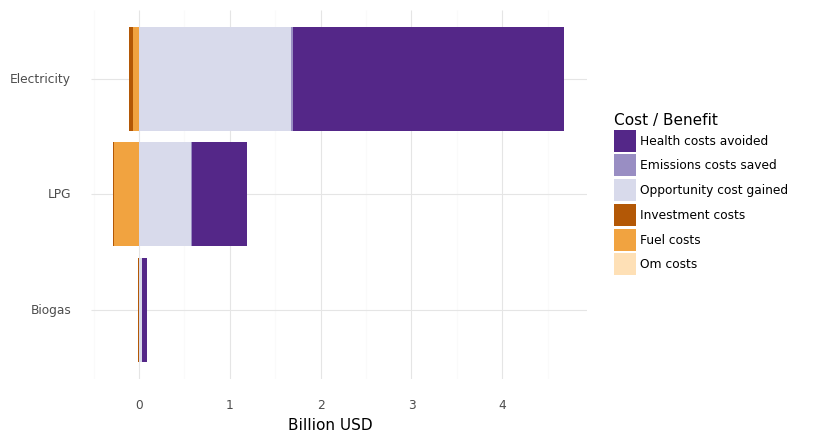

<ggplot: (123728822486)>

In [106]:
nepal.plot_costs_benefits(labels=labels, save=False, height=1.5, width=2)

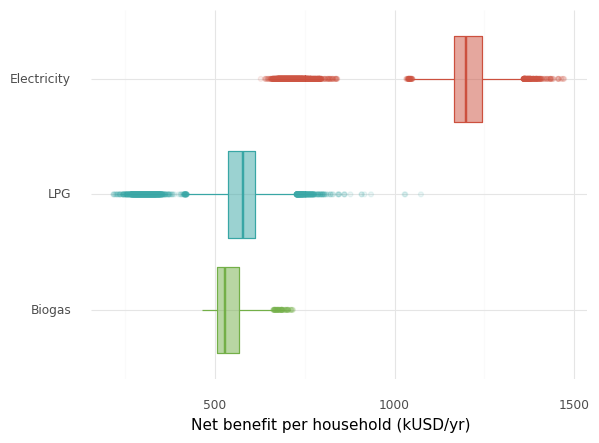

<ggplot: (123729887946)>

In [108]:
nepal.plot_benefit_distribution(type='box', groupby='None', cmap=cmap, labels=labels, save=False, height=1.5, width=3.5)

In [ ]:
# nepal.to_raster('max_benefit_tech')
# nepal.to_raster('net_benefit_Electricity')
# nepal.to_raster('net_benefit_LPG')
# nepal.to_raster('net_benefit_Biogas')
# nepal.to_raster('net_benefit_Collected_Traditional_Biomass')
# nepal.to_raster('net_benefit_Collected_Improved_Biomass')
# nepal.to_raster('maximum_net_benefit')
# nepal.to_raster('investment_costs')
# nepal.to_raster('Current_elec')
# nepal.to_raster('Elec_pop_calib')
# nepal.to_raster('value_of_time')
# nepal.to_raster('costs_Electricity')

In [ ]:
# nepal.to_image('max_benefit_tech', cmap=cmap, legend_position=(0.05, 0.33),
#            title=f'Maximum benefit cooking technology | Nepal', dpi=300,
#            labels=labels, legend=True, legend_title='Maximum benefit\ncooking technology', 
#            rasterized=True)

In [ ]:
# raster = RasterLayer('', 'max_benefit_tech', r'results\Output\max_benefit_tech.tif')

# poly = raster.polygonize().dropna()

# poly.rename({'raster_val': 'technology'}, inplace=True, axis=1)

# diss = poly.dissolve('technology').reset_index()

In [ ]:
nepal.to_pickle(f"{folder}/Policy2Results.pkl")

In [ ]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

In [55]:
folder = 'CCE Storylines'
nepal = OnSSTOVE.read_model(f"{folder}/Policy4Results.pkl")

In [56]:
nepal.summary()

,max_benefit_tech,Calibrated_pop,maximum_net_benefit,deaths_avoided,health_costs_avoided,time_saved,opportunity_cost_gained,reduced_emissions,emissions_costs_saved,investment_costs,fuel_costs,om_costs,salvage_value
0,Electricity,20.787376,28.708636,22421.583190,2986.233816,1.138932,1675.145837,9.718686,19.437373,118.223385,64.951323,0.0,69.478111
1,LPG,8.349624,39.437830,5131.835205,662.937278,1.242931,637.346084,3.713580,7.427160,38.229759,298.130027,0.0,28.986451


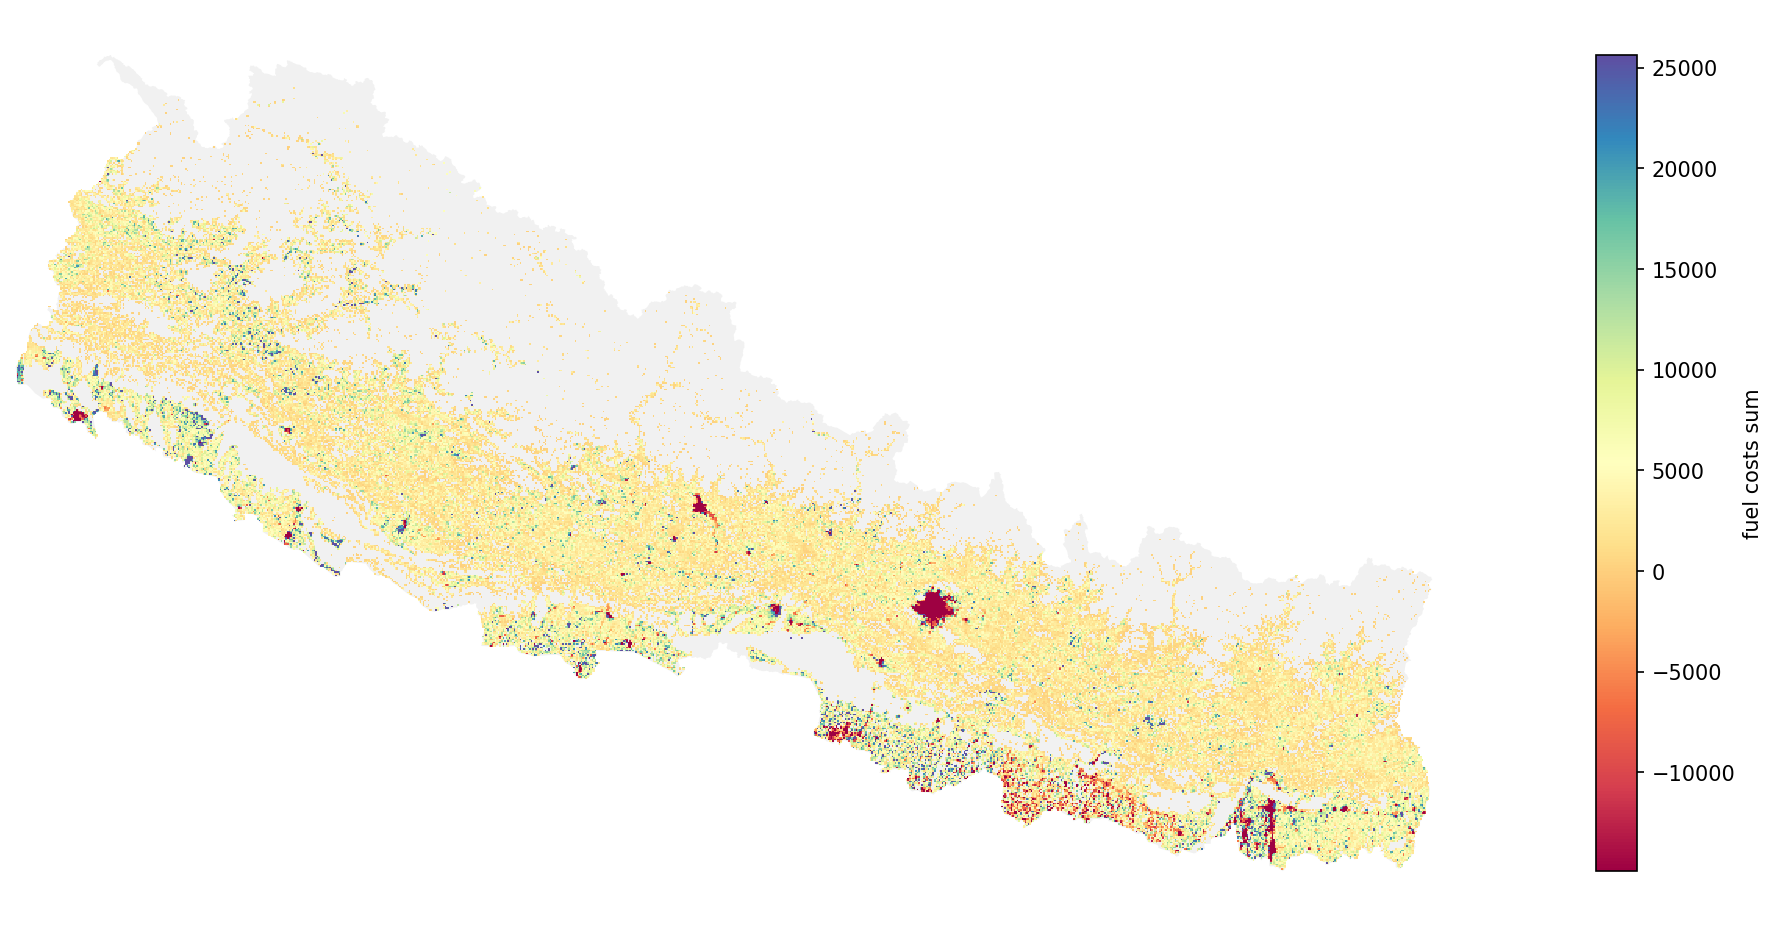

In [57]:
nepal.plot('fuel_costs', cmap='Spectral', cumulative_count=(0.01, 0.99), metric='sum')

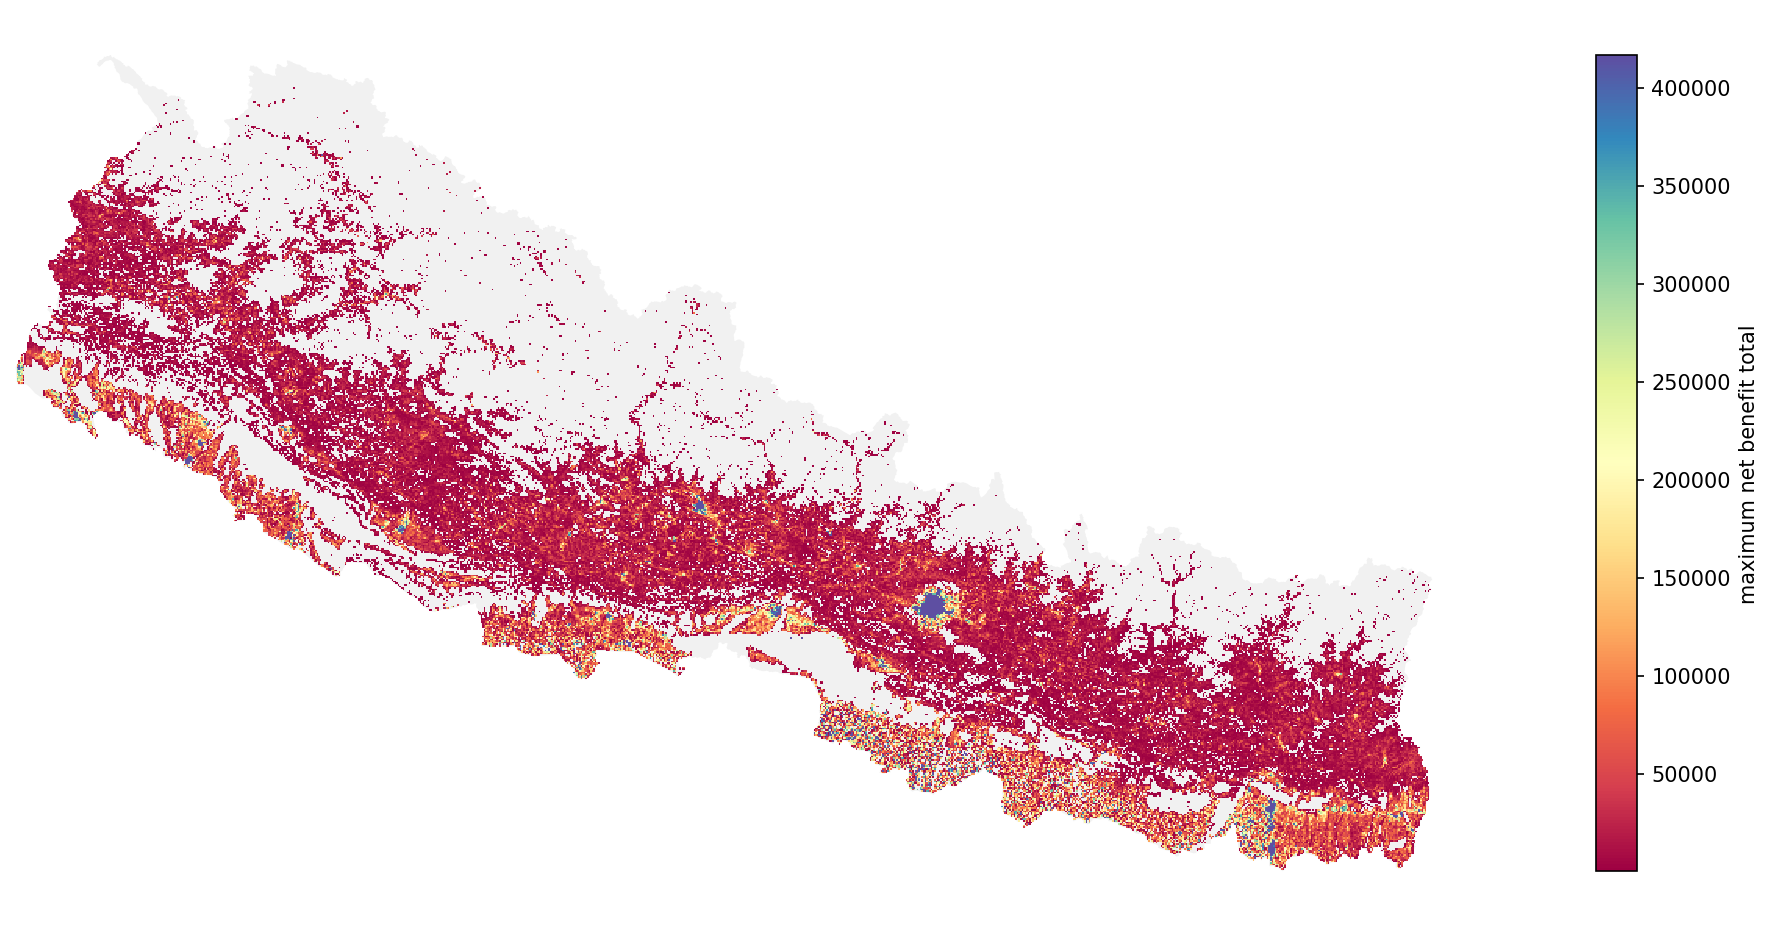

In [62]:
nepal.plot('maximum_net_benefit', cmap='Spectral', cumulative_count=(0.01, 0.99), metric='total')